In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [5]:
## MLP based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [8]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X: input, Y: labels for each input (what it is supposed to output)

for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        
        #print(''.join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
natalie
zoe
leah
hazel
violet
aurora
savannah
audrey
brooklyn
bella
claire
skylar
lucy
paisley
everly
anna
caroline
nova
genesis
emilia
kennedy
samantha
maya
willow
kinsley
naomi
aaliyah
elena
sarah
ariana
allison
gabriella
alice
madelyn
cora
ruby
eva
serenity
autumn
adeline
hailey
gianna
valentina
isla
eliana
quinn
nevaeh
ivy
sadie
piper
lydia
alexa
josephine
emery
julia
delilah
arianna
vivian
kaylee
sophie
brielle
madeline
peyton
rylee
clara
hadley
melanie
mackenzie
reagan
adalynn
liliana
aubree
jade
katherine
isabelle
natalia
raelynn
maria
athena
ximena
arya
leilani
taylor
faith
rose
kylie
alexandra
mary
margaret
lyla
ashley
amaya
eliza
brianna
bailey
andrea
khloe
jasmine
melody
iris
isabel
norah
annabelle
valeria
emerson
adalyn
ryl

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [9]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [10]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [11]:
# Create look-up table C

C = torch.randn((27, 2))
C

tensor([[ 4.0817e-02,  9.4265e-02],
        [ 1.7447e+00, -2.1347e-03],
        [-1.1305e+00, -4.5554e-01],
        [-2.3809e-01,  1.0305e+00],
        [-5.4756e-01, -6.6047e-01],
        [ 9.4027e-01, -7.3450e-01],
        [-7.1152e-01,  4.3086e-01],
        [ 9.3192e-02,  9.8578e-01],
        [ 7.4379e-01,  1.2850e+00],
        [ 1.4365e+00, -2.2736e-01],
        [ 1.2875e+00, -3.2178e-01],
        [ 2.0779e+00,  1.1355e+00],
        [ 6.2234e-01, -9.1878e-02],
        [ 1.0900e-02,  1.3026e+00],
        [ 2.8018e+00,  9.4378e-02],
        [ 6.8716e-01,  7.5166e-01],
        [ 3.9762e-01, -1.0416e+00],
        [ 1.0118e-01, -1.8058e-01],
        [-1.1913e-01,  3.8173e-01],
        [-1.0342e+00,  1.0729e+00],
        [ 1.3276e+00, -1.0056e+00],
        [-1.1505e+00, -1.9525e+00],
        [ 8.0078e-01,  1.5005e+00],
        [-6.3732e-01, -6.0037e-01],
        [ 1.2834e+00, -4.6533e-01],
        [-1.4553e+00,  5.1680e-01],
        [ 4.1104e-01,  4.9792e-01]])

In [12]:
emb = C[X] # embeds all integers
emb.shape 

torch.Size([228146, 3, 2])

In [13]:
emb

tensor([[[ 0.0408,  0.0943],
         [ 0.0408,  0.0943],
         [ 0.0408,  0.0943]],

        [[ 0.0408,  0.0943],
         [ 0.0408,  0.0943],
         [ 0.9403, -0.7345]],

        [[ 0.0408,  0.0943],
         [ 0.9403, -0.7345],
         [ 0.0109,  1.3026]],

        ...,

        [[ 0.4110,  0.4979],
         [ 0.4110,  0.4979],
         [-1.4553,  0.5168]],

        [[ 0.4110,  0.4979],
         [-1.4553,  0.5168],
         [ 0.4110,  0.4979]],

        [[-1.4553,  0.5168],
         [ 0.4110,  0.4979],
         [ 1.2834, -0.4653]]])

In [14]:
# hidden layer
W1 = torch.randn((6, 100)) # Weights (6 arrays of 100 neurons), 6 because it's 1 per embed value. Which values picks an array and uses the weight of the current neuron?  
b1 = torch.randn(100) # biases

In [16]:
#emb @ W1 + b1 # shapes cannot be multiplied

# all below do the same thing
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # concatenates 
torch.unbind(emb, 1) # removes dimension with index 1; equivalent to [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]
torch.cat(torch.unbind(emb, 1), 1).shape
#emb.view(32, 6)

torch.Size([228146, 6])

In [17]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # hidden layer

In [18]:
h

tensor([[ 0.5642,  0.3143, -0.8860,  ...,  0.5313,  0.9345, -0.5710],
        [ 0.8740,  0.9490,  0.9717,  ...,  0.5865,  0.9967,  0.9865],
        [-0.9870,  0.8436, -0.9871,  ..., -0.1589,  0.4083, -1.0000],
        ...,
        [-0.0403, -0.9825, -0.9997,  ...,  0.4280,  0.9572, -0.9984],
        [ 0.9991, -0.8627, -0.9982,  ...,  0.8279,  0.9396,  0.8871],
        [ 0.9945,  0.9984,  0.9974,  ..., -0.4329,  0.9930,  0.9285]])

In [19]:
h.shape

torch.Size([228146, 100])

In [20]:
# final layer
W2 = torch.randn((100, 27)) # Input, Output
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([228146, 27])

In [23]:
counts = logits.exp()
counts

tensor([[1.7085e-02, 1.3563e+06, 1.4048e-01,  ..., 9.7693e-03, 4.9473e-01,
         1.5729e-02],
        [5.5472e-01, 1.8406e+07, 1.9392e-04,  ..., 1.3359e-02, 1.0342e-05,
         5.7563e-03],
        [6.1964e-03, 2.4162e+00, 2.6657e+01,  ..., 1.1553e+05, 4.3895e-02,
         5.0505e+01],
        ...,
        [2.5227e-01, 1.0671e+01, 7.8863e-02,  ..., 3.0147e-01, 4.9935e+01,
         6.5862e-05],
        [2.2669e+02, 1.1483e+01, 6.2913e-03,  ..., 1.1192e-02, 4.7357e+00,
         2.2205e+02],
        [3.6008e+01, 2.1543e+05, 2.6153e-01,  ..., 1.9839e-03, 4.9387e-03,
         6.3051e-05]])

In [24]:
prob = counts / counts.sum(1, keepdims=True)

In [25]:
prob.shape

torch.Size([228146, 27])

In [26]:
prob[0].sum()

tensor(1.)

In [27]:
# loss
loss = -prob[torch.arange(logits.shape[0]), Y].log().mean()
loss

tensor(16.2504)

In [28]:
# ----------- organized -----------

In [29]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [30]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g) # Look-up table

W1 = torch.randn((6, 100)) # hidden layer weights
b1 = torch.randn(100) # hidden layer biases

W2 = torch.randn((100, 27)) # final layer weights
b2 = torch.randn(27) # final layer biases

parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [32]:
for p in parameters:
    p.requires_grad = True

In [33]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct (train random batches)
    ix = torch.randint(0, X.shape[0], (32,)) # in practice, using less batches decreases the gradient quality but the trade off is worth it  
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # hidden layer (32, 100)
    logits = h @ W2 + b2 # final layer (32, 17)
    loss = F.cross_entropy(logits, Y[ix]) # much more efficient and numerically correct
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #learning_rate = 1
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
#     lossi.append(loss.item())
        
#print(loss.item())

In [34]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # hidden layer (32, 100)
logits = h @ W2 + b2 # final layer (32, 17)
loss = F.cross_entropy(logits, Y) # much more efficient and numerically correct
loss

tensor(3.8612, grad_fn=<NllLossBackward0>)

In [853]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.1000, 0.1000, 0.1000,  ..., 0.0100, 0.0100, 0.0100])

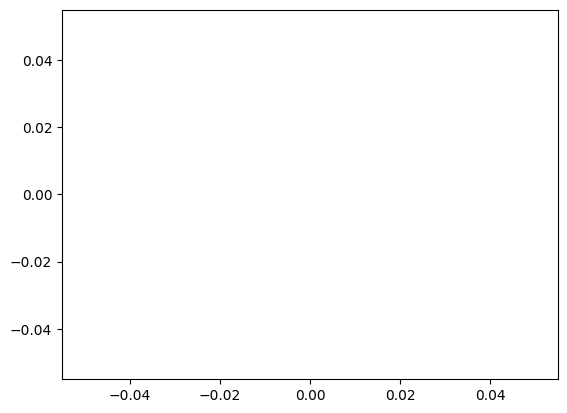

In [36]:
plt.plot(lri, lossi)

In [37]:
# training split, dev/validation split, test split
# 80%, 10%, 10%f

In [1005]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X: input, Y: labels for each input (what it is supposed to output)

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182561, 3]) torch.Size([182561])
torch.Size([22798, 3]) torch.Size([22798])
torch.Size([22787, 3]) torch.Size([22787])


In [1006]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182561, 3]), torch.Size([182561]))

In [1007]:
g = torch.Generator().manual_seed(2147483647)
n_characters = 27
n_dimensions = 7
C = torch.randn((n_characters, n_dimensions), generator=g) # Look-up table
n_neurons = 100 # n neurons on hidden layer
W1 = torch.randn((block_size*n_dimensions, n_neurons)) # hidden layer weights
b1 = torch.randn(n_neurons) # hidden layer biases
W2 = torch.randn((n_neurons, n_characters)) # final layer weights
b2 = torch.randn(n_characters) # final layer biases
parameters = [C, W1, b1, W2, b2]

In [1008]:
for p in parameters:
    p.requires_grad = True

In [1009]:
sum(p.nelement() for p in parameters) # number of parameters in total

5116

In [1010]:
#lre = torch.linspace(-3, 0, 1000)
lre = torch.linspace(-1, -2, 300000)
lrs = 10**lre
lrs

tensor([0.1000, 0.1000, 0.1000,  ..., 0.0100, 0.0100, 0.0100])

In [1011]:
lri = []
lossi = []
stepi = []

In [1012]:
batch_size = 128

for i in range(550000):
    # minibatch construct (train random batches)
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # in practice, using less batches decreases the gradient quality but the trade off is worth it  
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], block_size*n_dimensions) @ W1 + b1) # hidden layer (32, 100)
    logits = h @ W2 + b2 # final layer (32, 17)
    loss = F.cross_entropy(logits, Ytr[ix]) # much more efficient and numerically correct
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    #exp = lre[i]
    exp = -1
    
    if i > 250000:
        exp = -2
    if i > 450000:
        exp = -2.5
    
    lr = 10**exp 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(exp)
    stepi.append(i)
    lossi.append(loss.item())
    #lossi.append(loss.log10().item())
        
print(loss.item())

2.2157609462738037


In [1013]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], block_size*n_dimensions) @ W1 + b1) # hidden layer (32, 100)
logits = h @ W2 + b2 # final layer (32, 17)
loss = F.cross_entropy(logits, Ytr) # much more efficient and numerically correct
loss

tensor(2.1280, grad_fn=<NllLossBackward0>)

In [1014]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], block_size*n_dimensions) @ W1 + b1) # hidden layer (32, 100)
logits = h @ W2 + b2 # final layer (32, 17)
loss = F.cross_entropy(logits, Ydev) # much more efficient and numerically correct
loss

tensor(2.1649, grad_fn=<NllLossBackward0>)

In [1015]:
import numpy as np
min_index = np.argmin(lossi)
lri[min_index], lossi[min_index], stepi[min_index]

(-1, 1.6274356842041016, 249270)

Text(0, 0.5, 'loss')

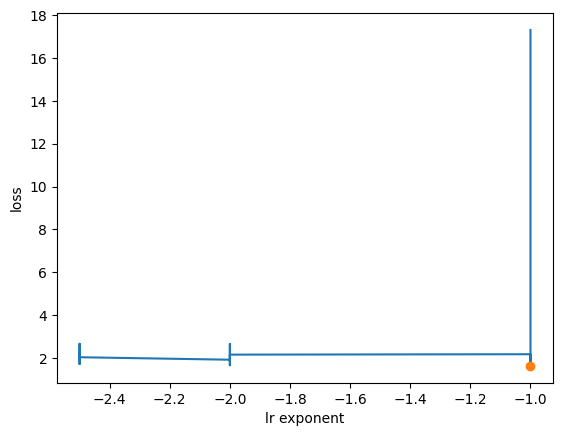

In [1016]:
plt.plot(lri, lossi)
plt.plot(lri[min_index], lossi[min_index], marker='o')
plt.xlabel("lr exponent")
plt.ylabel("loss")

Text(0, 0.5, 'loss')

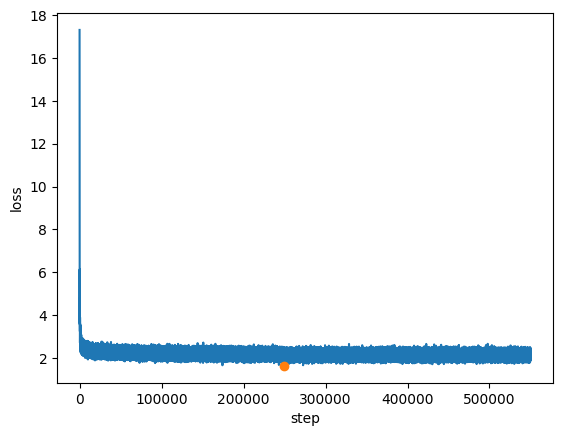

In [1017]:
plt.plot(stepi, lossi)
plt.plot(stepi[min_index], lossi[min_index], marker='o')
plt.xlabel("step")
plt.ylabel("loss")

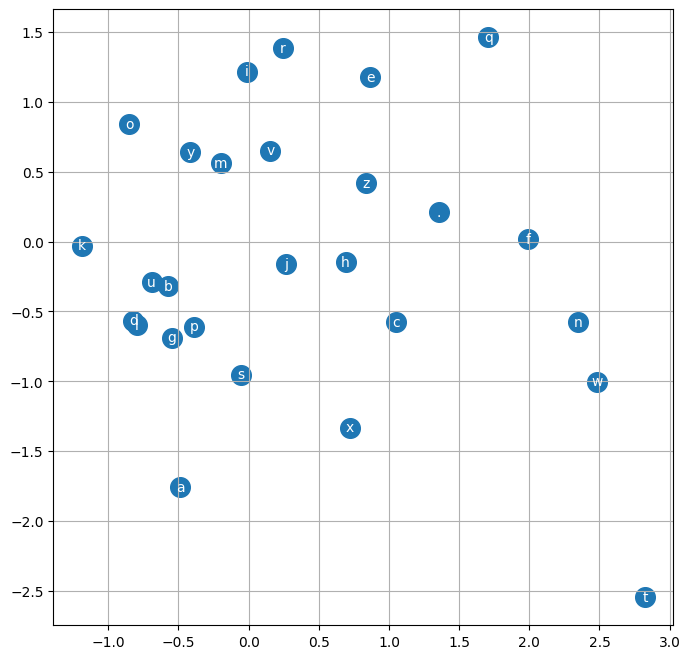

In [830]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [710]:
# beat: 2.1701 on dev split

# neurons on hidden layer
# number of dimensions
# number of characters (context)
# number of iterations
# batch size
# learning rate

In [995]:
loss

tensor(2.1636, grad_fn=<NllLossBackward0>)

In [1019]:
# sample from model

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(emb.shape[0], block_size*n_dimensions) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 # final layer
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

junide.
jakasah.
presay.
adin.
kai.
rito.
sabrayel.
kalania.
zamilevias.
dedaine.
imel.
sejainayla.
tezindellestion.
maj.
poyts.
jah.
jaylie.
reayae.
ocely.
jamiya.
